# Data Analysis Project: Keystroke Dynamics

Keystroke dynamics may be applied as a method of biometric authentication of users. Keystroke dynamics evaluate the manner and rhythm of typing of individuals. Multiple methods of computing different metrics have been used to research authentication using keystroke dynamics, for example: checking inter-key latencies between different letters, or computing the time intervals between individual keystrokes and the total time of typing of a specific piece of text. The combination of multiple of these metrics can allow to extract statistical data and create a machine learning model that can allow to identify individuals based on their typing patterns. 

The way a user is identified is by comparing a set of data extracted during a log in session with sets of data stored by the system for each registered user. A similarity score is given for each comparison made, and if one of those falls into a pre-defined tolerance limit, the used is successfully authenticated. This method is known as classification.

The efficiency of this system for identification is disputed when it comes to practical uses and implementation. Many factors can impact the speed and rhythm of typing on a user: the keyboard they are using, their alertness level, changes to their typing patterns due to injuries, or only using one hand to type. Furthermore, the speed of typing can vary between users, an expert or a beginner. According to a paper by Jarmo Illonen, a fast typer is easier to identify among other fast typers, as with a less experienced slower typer, who needs to search for keys, it is harder to have great predictability. This is why keystroke dynamics have been recommended more as verification methods, to supplement existing identification solutions, like detecting keystroke dynamics while typing a password.

Sources:
- M. Karnan, M. Akila and N. Krishnaraj, “Biometric personal authentication using keystroke dynamics: A review,” (online) Applied Soft Computing, vol. 11, no. 2, March 2011, p. 1565-1573. Available on: https://www.sciencedirect.com/science/article/abs/pii/S156849461000205X
- J. Ilonen, "Keystroke dynamics," (online) Advanced Topics in Information processing–lecture, 2003. Available on: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.99.9014&rep=rep1&type=pdf
-  K. Shenoy, “Keystroke Dynamics Analysis and Prediction,” (online) on Medium, January 18th, 2021. Available on: https://towardsdatascience.com/keystroke-dynamics-analysis-and-prediction-part-1-eda-3fe2d25bac04 




**Scenario:**
We are a group of four students: Alexandre, Stefan, Zihao and Zineb. 
Our goal is to create an Identification process that tells us whether a user, based on their typing behavior, is a registered user or not.

We split our group into two: Alexandre, Stefan and Zineb are considered registered users and the metrics related to their typing behavior are stored. Zihao plays the role of a new user, for which the system will decided whether he is an intruder or not.

The four of us type a certain text , during about 3 minutes and our keyboard activity is logged using our own written keylogger. We then process, analyse and use this data to answer our three research questions: *How to define a user's signature using keyboard dynamics?*, *Which metric is the most interesting to explore to identify a user?*, *How to detect an intruder in a keyboard dynamics authentication system?*.

## Contributions

All of the group members have knowledge of the entire project, but have taken on different roles in the project. Here is a list of responsibilities of each member:
- **Stefan:** 
    - did scientific research on keystroke dynamics, its practical use and scientific questions we wanted to answer in this project
    - found research on metrics used in previous studies to measure typing patterns
    - added explanations and comments to the report/notebook
    - did scientific research on distance measurements and its applications in keystroke dynamics
    - built the tests for P value variations in distances, and studied the implications of our choice
- **Zineb:**  
    - built the data visualisations (plots and graphs)
    - built the method to compute the statistics 
    - built the classification models
    - built the method to calculate the distance
    - built the recognition algorithm
    - added explanations, comments and result interpretations to the notebook
    - did scientific research for the graphs (which to choose, how to interpret them), the classifiers (which to choose and how they function) and the recognition algorithm (how to calculate the distance and define the threshold)
- **Alexandre:**
    - built the keylogger
    - built the method to preprocess the data
    - built the method to compute the statistics 
    - built the classification models
    - built the method to calculate the distance
    - built the recognition algorithm
    - did scientific research for the classifiers (which to choose and how they function) and the recognition algorithm (how to calculate the distance and define the threshold)
- **Zihao:**
    - created the optional HTML typing interface
    - provided suggestions in data preprocessing steps

## Keylogger

We use a keyloger for the first step of the project, the Data Acquisition. In order to extrapolate useful results and metrics that we can use in for further analysis, two keyloggers need to run simultaniously: one that logs every time a button is pressed, and another that logs every time a button is released. Our keylogger saves separate files for pressed and released buttons. We save a new file every 10 seconds with the keys pressed/released during that interval, over a timespan of 1 minute.

The logging parameters can be easily modified. In the current configuration, each keylogger saves a file every 10 seconds, over a total of 60 seconds. In the end, 12 files will be saved in two folders: 6 for pressed keys, 6 for released keys.

The keylogger works by triggering an event each time a button on the keyboard is pressed or released. The key is properly formatted with a timestamp of when it was pressed, and saved to a file. At the end of the SEND_REPORT_EVERY interval, the running text file is saved to the proper directory, and a new file is initialized. The keylogger exits at the end of the INTERRUPT_AFTER interval. When initializing the keylogger, the event type needs to be specified: "press" or "release".

**QuickStart:** on Windows, to run the keylogger, use the command line: ./start.bat [your name]  
Please read the README file of this project for more information on how to launch and use the keylogger

## Preprocessing the logs for known users

In [3]:
# Imports
import glob
import pandas as pd
import sys
import math

from datetime import datetime

Firstly, for each file in the key pressed and key released directories, we need to convert simple textual data into a useful data structure that is easy to manipulate. For our purposes, the ideal data structure is a DataFrame from Pandas.

A DataFrame is two-dimensional, size-mutable, potentially heterogeneous tabular data. This data structure also contains labeled axes (rows and columns). Arithmetic operations align on both row and column labels. It represents the primary Pandas data structure.

Once our pressed and released data is properly formatted, we can merge them into a single file, detailing for each registered user and for each key when it was pressed and released in a single dataset. In order to do that, we start by removing any duplicates that might have occurred when saving the separate text files (this is because when a key is pressed down, our logger logs it multiple times). Then, for each timestamp of a released key, we search for the nearest timestamp for which the same key was pressed. We can then take that data and save it in a single dataset. We also identify in this dataset the name of the user who created this data, in order to properly differentiate between user datasets in our analysis.

Finally we measure a few key metrics and add them to our final dataset, which is saved as a csv file for each registered user:

- press_press_time: a list of time intervals between different subsequent key presses.
- press_release_time: a list of time intervals that represent the time interval for which a key is released and the next key is pressed.
- hold_time: a list of time intervals that represent the time for which a certain key is pressed

These three features were chosen because they are significant in the behavior of a user, they capture the speed and the insistance with which they type

In [4]:
def preprocess(user=None, group="registered"):

    """
        This script will pre-process the raw data collected by the keylogger.py script, the steps are as follows:
        1) parse each press and release .txt files by reading the events sequentially
        2) map each released event to its pressed event
        3) extract features such as "press_press_time", "press_release_time", "release_release_time"
    """

    # Collect .txt keylogs paths
    press_files = glob.glob(f"logs/{user}/press/*.txt")
    press_rows = []
    # Initialize array to concatenate press and release events
    release_files = glob.glob(f"logs/{user}/release/*.txt")
    release_rows = []

    # Parse press keylogs
    for press_file in press_files:
        with open(press_file) as fp:
            line = fp.readline()
            while line:
                # Handle linebreak exception 
                if line == "\n":
                    line = fp.readline()
                    continue
                # extract event's timestamp and key
                timestamp = datetime.strptime(
                    line.strip().split(" - ")[0], '%Y-%m-%d %H:%M:%S %f')
                key = line.strip().split(" - ")[1].lower()
                press_rows.append({
                    "timestamp": timestamp,
                    "key": key
                })
                line = fp.readline()

    # Parse release keylogs
    for release_file in release_files:
        with open(release_file) as fp:
            line = fp.readline()
            while line:
                # Handle linebreak exception 
                if line == "\n":
                    line = fp.readline()
                    continue
                # extract event's timestamp and key
                timestamp = datetime.strptime(
                    line.strip().split(" - ")[0], '%Y-%m-%d %H:%M:%S %f')
                key = line.strip().split(" - ")[1].lower()
                release_rows.append({
                    "timestamp": timestamp,
                    "key": key
                })
                line = fp.readline()

    # Convert arrays to dataframes for easier manipulation
    press_df = pd.DataFrame(press_rows)
    release_df = pd.DataFrame(release_rows)

    # Map release events to their corresponding press event
    dataset_rows = []
    # The mapping will be done key by key.
    # For example we will map all "[SPACE]" keys together before mapping "e" keys    
    for _, row in release_df.drop_duplicates(subset=['key']).iterrows():
        # sub_df contains all release events recorded for key {row['key']}
        sub_df = release_df[release_df["key"] == row['key']]
        # lower_bound is a time-cursor that records the last known release event timestamp
        lower_bound = None
        for sub_id, sub_row in sub_df.reset_index().iterrows():
            try:
                # higher_bound runs through the latest release event timestamp
                higher_bound = sub_row["timestamp"]
                if sub_id == 0:
                    # match the release event to the press event
                    # when a user holds a key for a long amount of time, the keylogger will records multiple press events, so we will keep only the first press event timestamp                    
                    press_time = press_df[(press_df["key"] == sub_row["key"]) & (
                        press_df["timestamp"] < higher_bound)].iloc[0]["timestamp"]
                else:
                    press_time = press_df[(press_df["key"] == sub_row["key"]) & (press_df["timestamp"] < higher_bound) & (press_df["timestamp"] > lower_bound)].iloc[0]["timestamp"]
                lower_bound = higher_bound
                dataset_rows.append({
                    "key": sub_row["key"],
                    "pressed": press_time,
                    "released": sub_row["timestamp"],
                    "user": user
                })
            except:
                continue

    dataset = pd.DataFrame(dataset_rows).sort_values(['pressed'])

    # Features extraction

    # Hold time is computed on the whole columns rather than row by row
    dataset["hold_time"] = (dataset["released"] -
                            dataset["pressed"]) / pd.Timedelta(microseconds=1)
    
    # press_press_time and press_release_time are computed row by row
    press_press_time = []
    press_release_time = []
    for index, row in dataset.reset_index().iterrows():
        # press_press_time is the time between 2 consecutive press events
        press_press_delta = (dataset.iloc[index+1]["pressed"] -
                             dataset.iloc[index]["pressed"]) / pd.Timedelta(microseconds=1)
        press_press_time.append(press_press_delta)
        # press_release_time is the time between the previous release event and the current press event
        press_release_delta = (
            dataset.iloc[index+1]["pressed"] - dataset.iloc[index]["released"]) / pd.Timedelta(microseconds=1)
        press_release_time.append(press_release_delta)

        if index == len(dataset) - 2:
            dataset = dataset.iloc[:-1 , :]
            break

    # Add features to final dataset
    dataset["press_press_time"] = press_press_time
    dataset["press_release_time"] = press_release_time
    
    # Save dataset as a .csv file that will be used for Data Mining
    kb_dataset = dataset.copy().reset_index().drop(columns=['index'])
    if group == "registered":
        kb_dataset.to_csv(f"datasets/{group}/{user}_data.csv", index=False)

    return kb_dataset

In [5]:
# Preprocess the logs for every registered user in order to obtain a dataset with the key metrics
# Please note that this cell takes a bit of time to run
registered_users = ["alex", "stefan", "zineb"]
for user in registered_users:
    preprocess(user, group="registered")

Some users type much faster than others, and therefore in the same lapse of time log a lot more data than others. For instance, Zineb recorded 2000 lines of logs whereas Stefan and Alexandre average around 1500 during the same time interval.

We choose to balance our datasets in order not to bias the models we build, i.e provide the models the same amount of data for each user during the training so as to not make it overfit on one of them. In order to achieve that, we decided to crop the datasets of each user, for them to have the same amount of logs as the one who has registered the fewest entries.

In [6]:
def cropDataFrames():
    dataframes = []
    files = glob.glob(f"datasets/registered/*.csv")
    for file in files:
        dataframes.append(pd.read_csv(file))
    small = 500000 
    for dataframe in dataframes:
        # Finding the length of the smallest dataframe
        small = small if len(dataframe) > small else len(dataframe)
    # Cropping the dataframes to the length of the smallest
    for dataframe in dataframes:
        user = dataframe['user'][0]
        new_dataframe = dataframe[:small-1]
        new_dataframe.to_csv(f"datasets/registered/{user}_data.csv", index = False)

In [7]:
cropDataFrames()

## Statistical Analysis

In this section, we statistically analyse the data we have gathered for each of our users. We will be combining graphical methods with calculations in order to get a better understanding on how each of the registered user behave. We wish to bring an answer to the following question: **Which metric is the most interesting to explore to identify a user?**

In [8]:
import pandas as pd
import glob
import json
import statistics

### Computing the statistics

We compute several main statistics to start with, connected to our main metrics in the dataset:

- average_hold_time: average hold time, i.e the average duration the user is pressing on a key
- average_press_press_time: average time between presses, i.e the average duration the user takes from pressing one key to pressing the following
- average_press_release_time: average time between press and release of different keys, i.e the average duration the user takes from pressing a key to release the following one
- apm: number of key presses per minute
- error_rate: error rate percentage, i.e the number of times backspace is pressed over 100 keys pressed

In [9]:
# Statistical analysis
def compute_statistics(dataset):
    # Calculating the different statistics
    
    average_hold_time = dataset["hold_time"].mean()
    
    average_press_press_time = dataset.iloc[:len(
        dataset)-1]["press_press_time"].mean()
    
    average_press_release_time = dataset.iloc[:len(
        dataset)-1]["press_release_time"].mean()
    
    values = list(dataset['press_press_time'].values)
    mean = sum(values)/len(values)
    # Calculating the apm: numnber of actions per minutes, using the press press time
    # As it's the time between pressing two keys (= two actions)
    apm = 60 * math.pow(10, 6) / mean
    
    error_rate = len(
        dataset[dataset["key"] == "[backspace]"]) * 100 / len(dataset)
    
    ret = {
            "average_hold_time": average_hold_time,
            "average_press_press_time": average_press_press_time,
            "average_press_release_time": average_press_release_time,
            "user": dataset['user'].iloc[0],
            "apm": apm,
            "error_rate": error_rate
        }
    return ret

In [10]:
# Loading the preprocessed data into one dataframe, and calculating statistics
def loadData(group="registered", user=None):
    filePath = ''
    
    if user is not None:
       filePath =  f"datasets/{group}/{user}_data.csv" 
    # If we don't have user specified, we load all the available files
    else:
        filePath =  f"datasets/{group}/*.csv"
    files = glob.glob(filePath)
    rows = []
    dataframe = pd.DataFrame()
    
    for file in files:
        dataset = pd.read_csv(file)
        dataframe = dataframe.append(dataset)
        
        # Calling upong the statistical analysis method
        stats = compute_statistics(dataset)
        stats["user"] = dataset.iloc[0]["user"]
        rows.append(stats)
        
    # We remove absurd values, that we know come from the keylogger bugs
    dataframe = dataframe[abs(dataframe['hold_time'])<= 3*math.pow(10, 6)]
    dataframe = dataframe[abs(dataframe['press_release_time'])<= 3*math.pow(10, 6)]

    statistics = pd.DataFrame(rows)
    statistics.to_csv("statistics.csv")

    return dataframe, statistics

In [11]:
# We load the data of all the registered users (that have their data under the datasets/registered folder)
# We also retrieve a summary of statistics
dataframe, statistics = loadData('registered')

A look into the dataframe we will be using for the analysis

In [12]:
# Combined dataframe
dataframe

,key,pressed,released,user,hold_time,press_press_time,press_release_time
0,[alt],2021-11-22 11:16:11.936705,2021-11-22 11:16:13.449099,alex,1512394.0,46856.0,-1465538.0
1,[tab],2021-11-22 11:16:11.983561,2021-11-22 11:16:12.163496,alex,179935.0,520494.0,340559.0
2,[tab],2021-11-22 11:16:12.504055,2021-11-22 11:16:12.628326,alex,124271.0,302550.0,178279.0
3,[tab],2021-11-22 11:16:12.806605,2021-11-22 11:16:12.933453,alex,126848.0,486276.0,359428.0
4,[tab],2021-11-22 11:16:13.292881,2021-11-22 11:16:13.402230,alex,109349.0,334301.0,224952.0
...,...,...,...,...,...,...,...
1460,[backspace],2021-11-22 11:19:48.955557,2021-11-22 11:19:49.017881,zineb,62324.0,138693.0,76369.0
1461,[backspace],2021-11-22 11:19:49.094250,2021-11-22 11:19:49.185869,zineb,91619.0,80753.0,-10866.0
1462,"""",2021-11-22 11:19:49.175003,2021-11-22 11:19:49.252747,zineb,77744.0,612143.0,534399.0
1463,[maj],2021-11-22 11:19:49.787146,2021-11-22 11:19:49.974448,zineb,187302.0,86581.0,-100721.0


### Statistics visualisation

Using the statistics calculated in the previous step, we can now plot multiple graphs that will help us analyze the data we've collected, as well as the metrics measured, in order to have a better understanding of each of the user's typing behavior and to extract the most possible information about which metric to use to help us identify a user using keystroke analysis. 

In [13]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from pylab import rcParams
import math

# Features chosen for now using the literature
features = ['hold_time', 'press_press_time', 'press_release_time']

#### General statistics

A table view for key statistical metrics for each user. We can see that for the data collected, the hold time and press-release time have varied values, which might implicate that those metrics can help us distinguish between users.

We notice the following:
- Zineb has a very distinctive APM, 1/3 higher than the two other users -> this is a key feature for her, this also goes in hand with her average hold time than is much smaller than for the others
- Stefan has a distinctive error_rate, with at least 2% higher than the other users -> this is a key feature for him
- Alexandre has a very distinctive average press-release time, more than 10 times smaller than the other users -> this is a key feature for him
- Alexandre and Stefan have very similar average press-press times, which means that this is not the best feature to choose in order to differentiate between them

In [14]:
# A look into the statistics we've calculated
statistics

,average_hold_time,average_press_press_time,average_press_release_time,user,apm,error_rate
0,199006.169283,200732.006148,1685.929645,alex,298.967146,3.754266
1,113871.811604,202644.639344,88753.450137,stefan,296.228273,6.211604
2,87456.731741,148692.058743,61231.954918,zineb,402.692528,4.163823


#### Box Plots

We created Box plots for each metric available per entry (press-press time, press-release time and hold time) and each user, in order to view its repartition by quartile. This allows us to further identify behaviors specific to each user.

We notice the following:
- Concerning the hold time: Zineb has the thinest box plot, indicating that her hold times are overall closer to each other, than the two other users. Zineb also has a box plot that sits lower than others, indicating that she has hold times generally smaller than the others. Stefan's median isn't in the middle of the box, indicating that the majority of his values are in the upper range. 
- Concerning the press-press time: Alex's median isn't in the middle of the box, indicating that the majority of his values are in the upper range. For all users, the top quartile is quite larger than the bottom one, indicating that the values overall situate in the higher range.
- Concerning the press-release time: This features shows significant difference amongst the users. It's mainly caused by the presence of outliers in the negatives. We believe this to be because of the holding keys such as shift in order to type numbers in french keyboards.
- Overall, we notice an amount of outliers, which we think are because of key holding in order to type special characters and numbers.

In [15]:
# Plotting the box plots
def boxPlotStats(dataframe):    
    fig, axs = plt.subplots(3, 3, figsize=(20, 10))
    fig.subplots_adjust(top=2, hspace=0.4)
    n=0
    for feature in features:
        for user in registered_users:
            axs[int(n/3), int(n%3)].text(.1,.9,user, horizontalalignment='left',transform=axs[int(n/3), int(n%3)].transAxes)
            axs[int(n/3), int(n%3)].boxplot(dataframe[dataframe['user']==user][feature])
            axs[int(n/3), int(n%3)].set_title(f"{feature} (microseconds)")
            n+=1
        

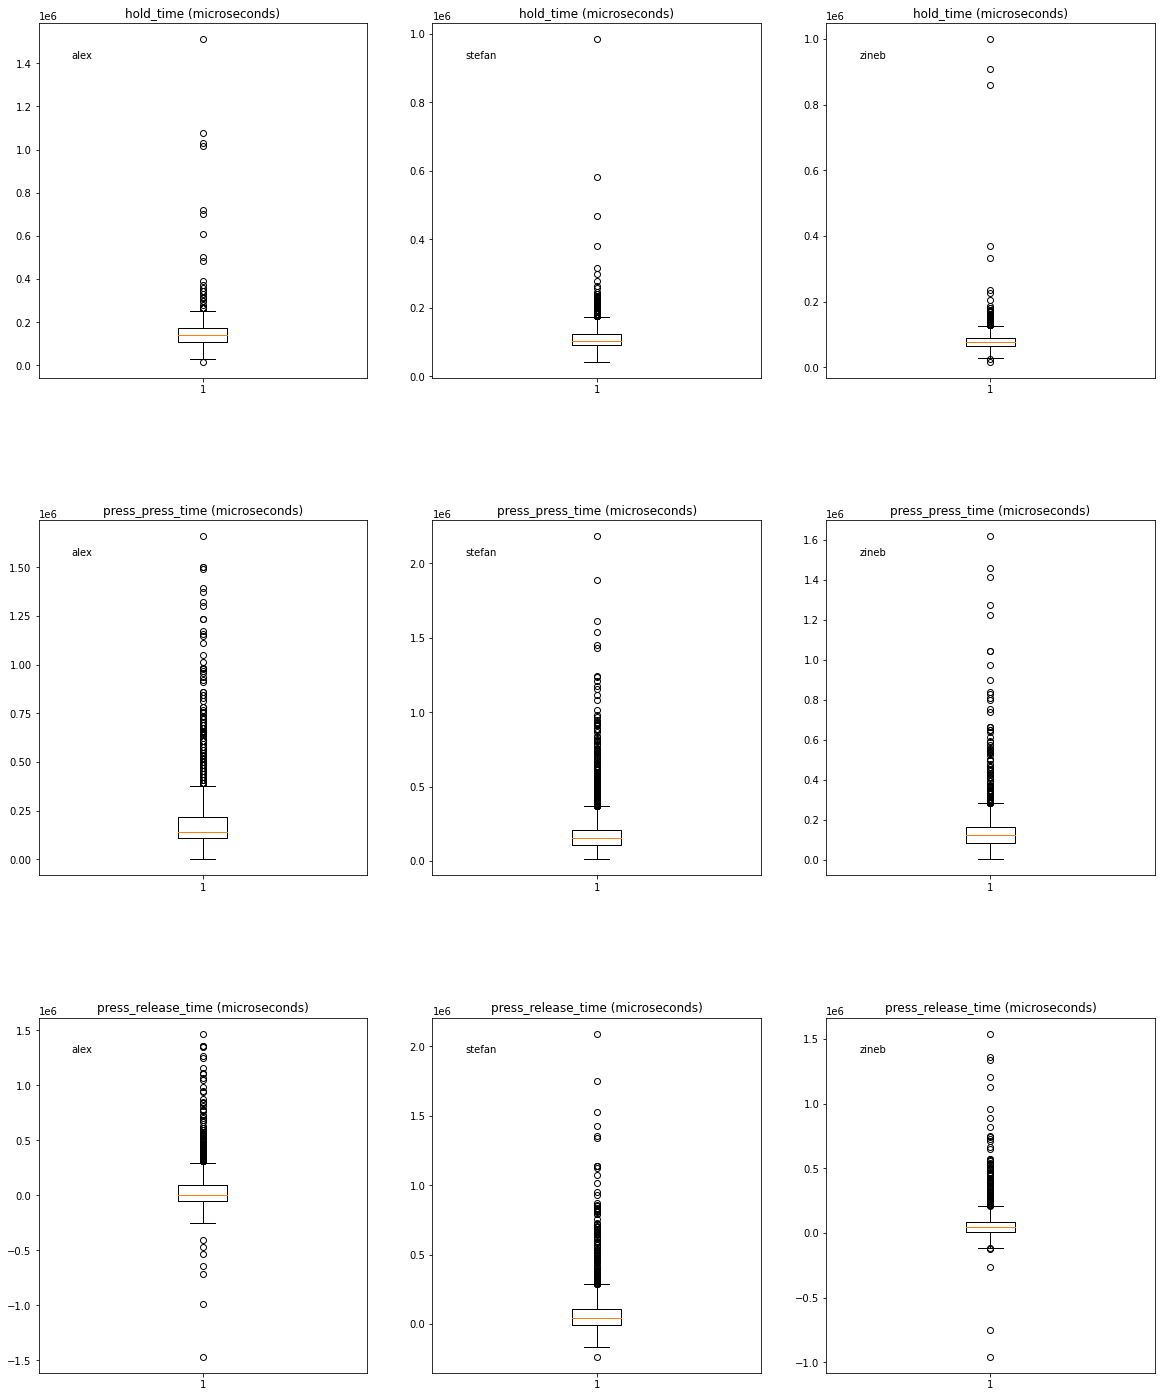

In [16]:
boxPlotStats(dataframe)

#### Bar charts

We plot the distribution of each metric available per entry (press-press time, press-release time and hold time) and for each user on the dataset we've created.
The hold-time duration shows similar distributions for Stefan and Zineb, which makes this metric less interesting to analyse if we want to distinguish the two. However, the press-press metric is interesting, since there are very different distributions among the different users.

In [17]:
# Plotting the bar charts
def barchartStats(dataframe):
    merged = dataframe.copy()

    # Rounding to closest milisecond in order to not have a chart that's too dispersed
    for feature in features:
        merged[feature] = merged[feature].apply(lambda x: round(x/1000))
    fig, axs = plt.subplots(3, 3, figsize=(20, 10))
    fig.subplots_adjust(top=2, hspace=0.4)
    
    n=0
    for feature in features:
        for user in registered_users:
            mm = pd.DataFrame(merged[merged['user']==user].groupby(feature)[feature].count()).rename(columns={feature:'count'}).reset_index()
            axs[int(n/3), int(n%3)].bar(mm[feature], mm['count'])
            axs[int(n/3), int(n%3)].set_ylabel('count')
            axs[int(n/3), int(n%3)].set_xlabel('duration (ms)')
            axs[int(n/3), int(n%3)].set_title(f"{feature} - {user}")
            n+=1

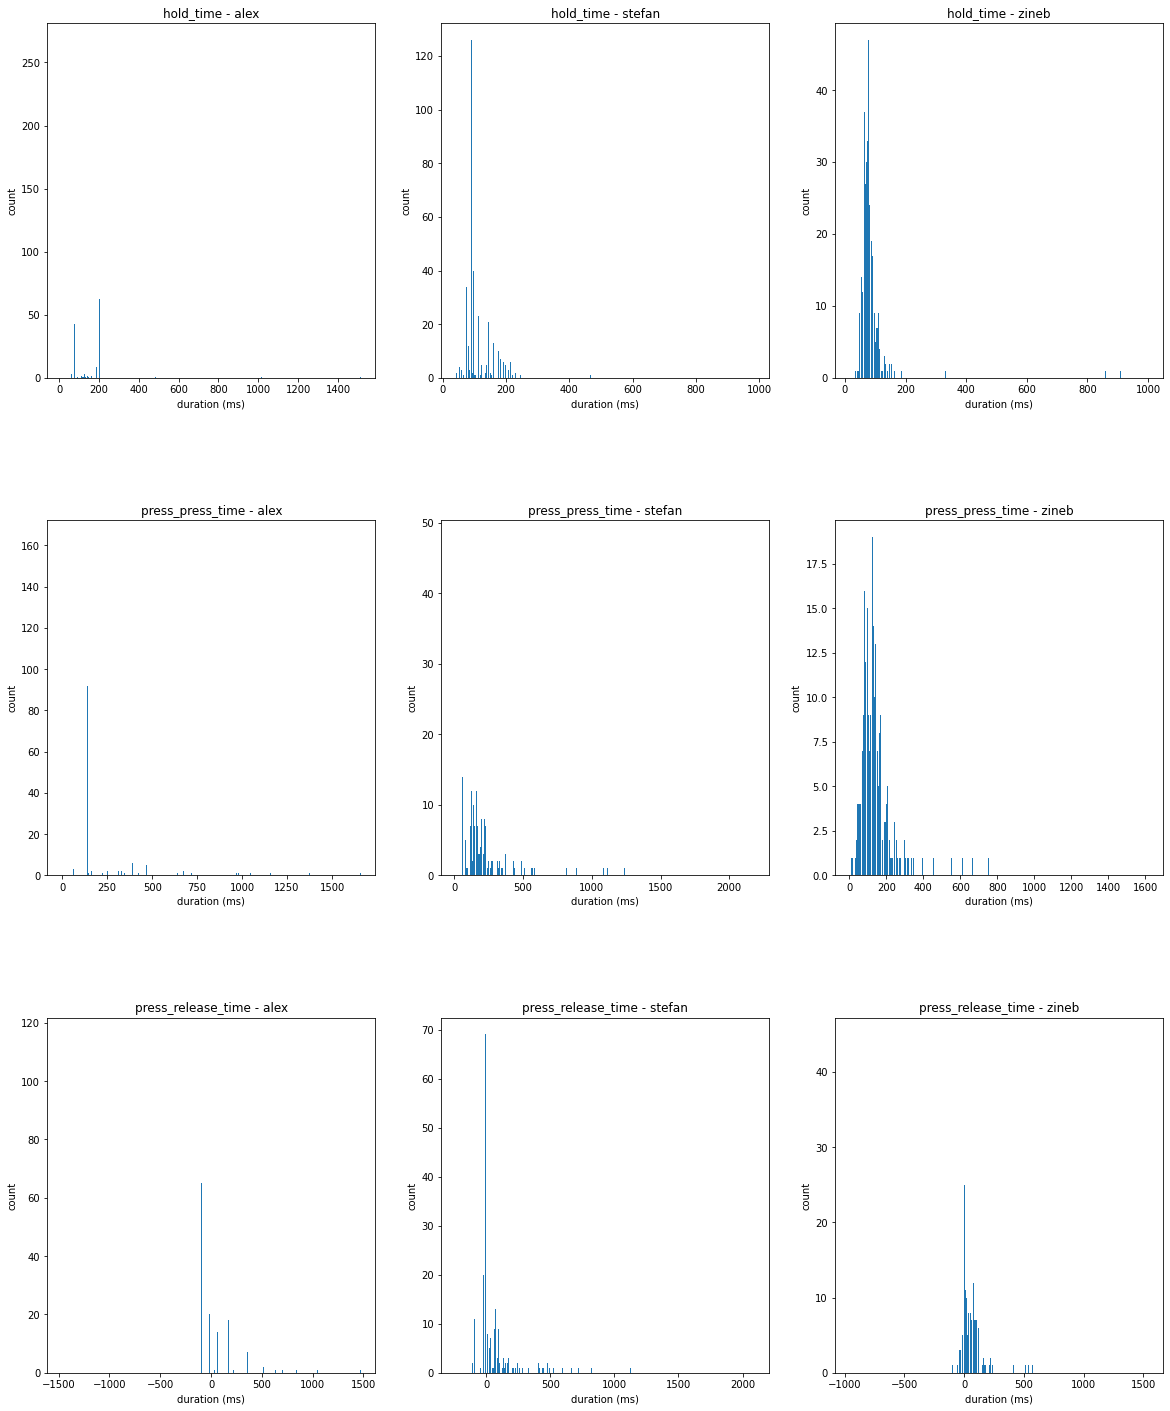

In [18]:
barchartStats(dataframe)

#### Feature correlation plots

We create a correlation plot between the different features available per entry (press-press time, press-release time and hold time) we have gotten from the literature. We can see that there is a vert high correlation between the press-press time and the press-release time: 0.94. This indicates that they are very similar, as they essentially indicate the same things.
Furthermore, by viewing the correlation between the press-release time and the outcome (user), we see that it's very small: 0.03, and therefore it's not that important in terms of information held. Even though the correlation between the user and the press-press time is also relatively smaller, it's still four times higher than the one for the press-release.

On the other hand, we conclude that there is a big contrast between the hold time and press-release time as well as the press-press time, which means that these metrics can be contrasting and deciding factors to study when identifying a user.

This observation makes us questions whether we should keep both press-press and press-release time, or keep only press-press time.

In [19]:
# Plotting the correlation plots
def correlationPlot(dataframe):
    rcParams['figure.figsize'] = 10, 10
    fig = plt.figure()
    ax = sns.heatmap(dataframe.corr(), annot=True, fmt=".2f")
    ax.set_title('Correlation plot between the features hold_time, press_press_time, press_release time and user')
    plt.show()

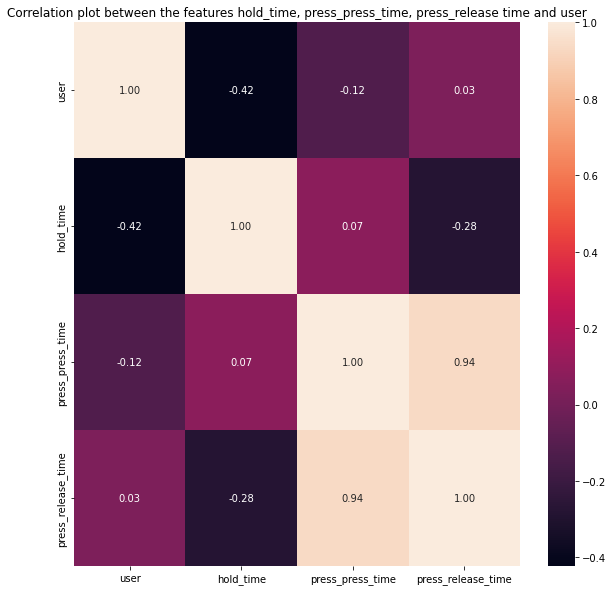

In [20]:
# Enconding the user in order to have the outcome part of the heat map
def encode_df(dataframe):
    dataframe = dataframe.copy()
    le = LabelEncoder()
    dataframe['user'] = le.fit_transform(dataframe['user'])
    return dataframe

encoded_dataframe = encode_df(dataframe[['user', 'hold_time', 'press_press_time', 'press_release_time']])
correlationPlot(encoded_dataframe)

#### Density charts

In order to deny or confirm our intuition about dropping the press-release time from our analysis, we plot the density of each feature regarding the registered users. This allows us to see how well do the features separate the users.

The hold time density is especially interesting, with peaks that are significant in density and different for each user, making identification and classification easier to separate users. The same applies to the press-release metric. However, the press-press density plot does show an almost identical curve between two users, which can be a problem if this metric is used to differentiate between the two.

This makes us believe the opposite as the former operation: even though the press-press time contributes more to the decision of the outcome, it does not separate well between two of the registered users we have.

In [21]:
# Plotting the density charts
def densityChartPlot(dataframe):    
    rcParams['figure.figsize'] = 15, 20

    # Separating data based on users
    outcome_alex = dataframe[dataframe['user']=='alex'][features]
    outcome_stefan = dataframe[dataframe['user']=='stefan'][features]
    outcome_zineb = dataframe[dataframe['user']=='zineb'][features]

    # Creating the figure
    fig, axs = plt.subplots(3, 1)
    fig.suptitle('Features densities for users alex, stefan, zineb')
    plt.subplots_adjust(left = 0.25, right = 0.9, bottom = 0.1, top = 0.95,
                        wspace = 0.2, hspace = 0.4)

    colors = ['blue', 'red', 'orange']
    
    i = 0
    # Creating a chart for each feature
    for feature in features: 
        ax = axs[i]
        # One line per user
        outcome_alex[feature].plot(kind='density', ax=ax, subplots=True, 
                                    sharex=False, color=colors[0], legend=True,
                                    label=feature + ' for User = Alex')
        outcome_stefan[feature].plot(kind='density', ax=ax, subplots=True, 
                                    sharex=False, color=colors[1], legend=True,
                                    label=feature + ' for User = Stefan')
        outcome_zineb[feature].plot(kind='density', ax=ax, subplots=True, 
                                    sharex=False, color=colors[2], legend=True,
                                    label=feature + ' for User = Zineb')
        ax.set_xlabel(feature + ' values')
        ax.set_title(feature + ' density')
        ax.grid('on')
        ax.set_xlim(-600000, 600000)
        i+=1
    plt.show()

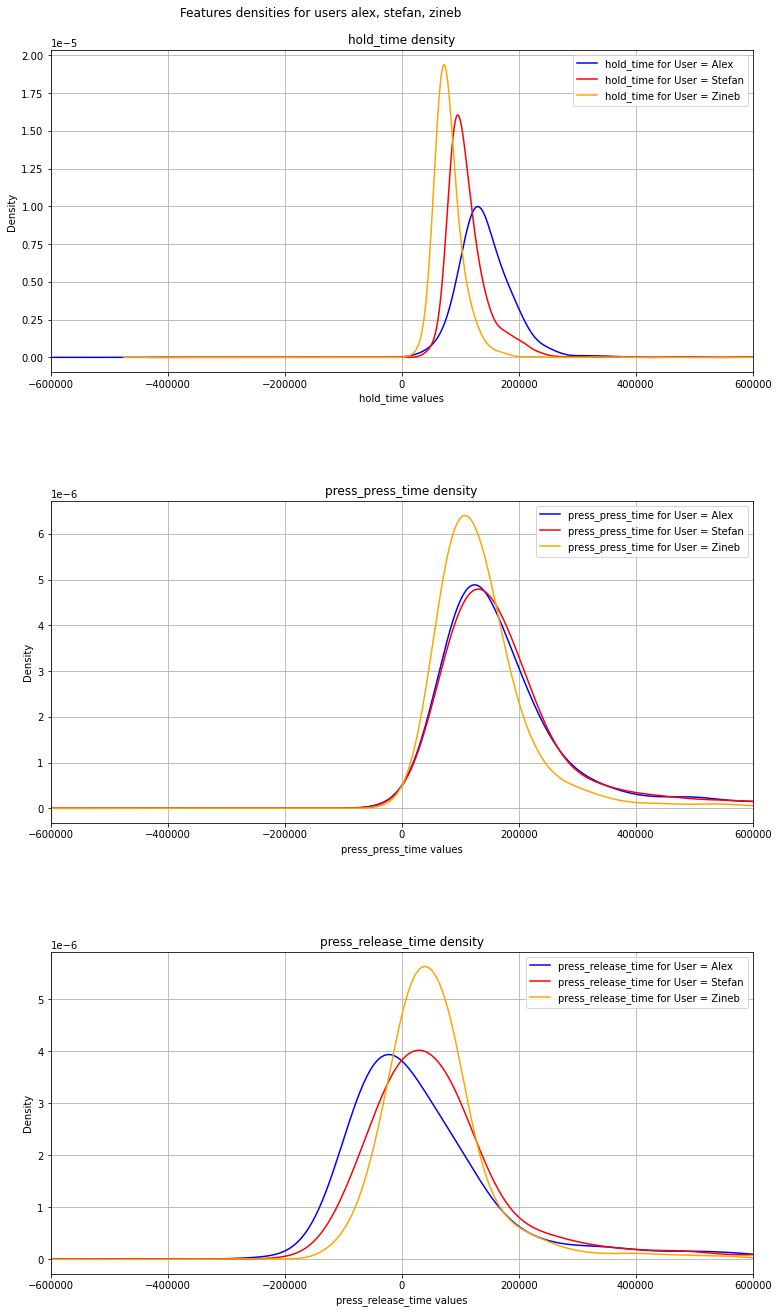

In [22]:
densityChartPlot(dataframe)

In conclusion of this first part, we are able to answer the first of our questions, **Which metric is the most interesting to explore to identify a user?**: we choose hold time, press-press time and press-release time, apm and error rate.

From the average statistics we have calculated, it is clear that the apm and error rate are a key metric to identify a user, as they largely differ.

When it comes to the others, although we have seen some incentives to drop one of the press-press or press-release, we have finally decided against it for the following reasons: although they are highly correlated, and press-release participates significantly less in the decision of the outcome, the press-press feature does not separate well for two of our three registered users. Furthermore, our dataset is quite small, and it is not in the current state of the project to scale up, therefore we can allow ourselves to keep all three features and not run into computation capacity issues, in order to reach a better accuracy. 

## Modelling the data


In this section, we build models to fit the data that we have for them to be able, when provided with data from a user (registered or not), to provide a decision on whether it is a known user or not. We train and test our models only on the features available per entry (press-press time, press-release time and hold time), and we will be using apm and error rate for a complementary analysis in the following section.

### Cluster visualisation

Here is our first attempt to identify clusters manually using simple statistical evaluation. We do scatter plots of the values of two metrics available per entry (press-press time, press-release time and hold time) for each user, doing so by project in a 2-dimension space, for each distinct pairs of metrics. The data for each user is shown in a different color. We can identify a lot of overlap in the three "clusters" which means most of the values produced by all three users are quite similar. There are individuals in our dataset that have managed to produce more outliers than others (for example Alex, in blue). 

This visualisation does not help us much to distinguish between users, and we will be instead using models to identify clusters.

In [23]:
# Plotting the clusters
def clusterVisualisation(dataframe):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    fig.subplots_adjust(top=2, hspace=0.4)
    n=0
    # Projecting in 2D dimension of pairs of features
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            values = dataframe[[features[i], features[j], 'user']]
            col = values['user'].map({
                'alex': 'blue',
                'stefan': 'red',
                'zineb': 'orange'
            })
            # Creating a data point for each entry in the dataframe
            values.plot.scatter(x=features[i], y=features[j], c=col, ax=axs[n])
            axs[n].set_ylabel(features[j])
            axs[n].set_xlabel(features[i])
            n+=1

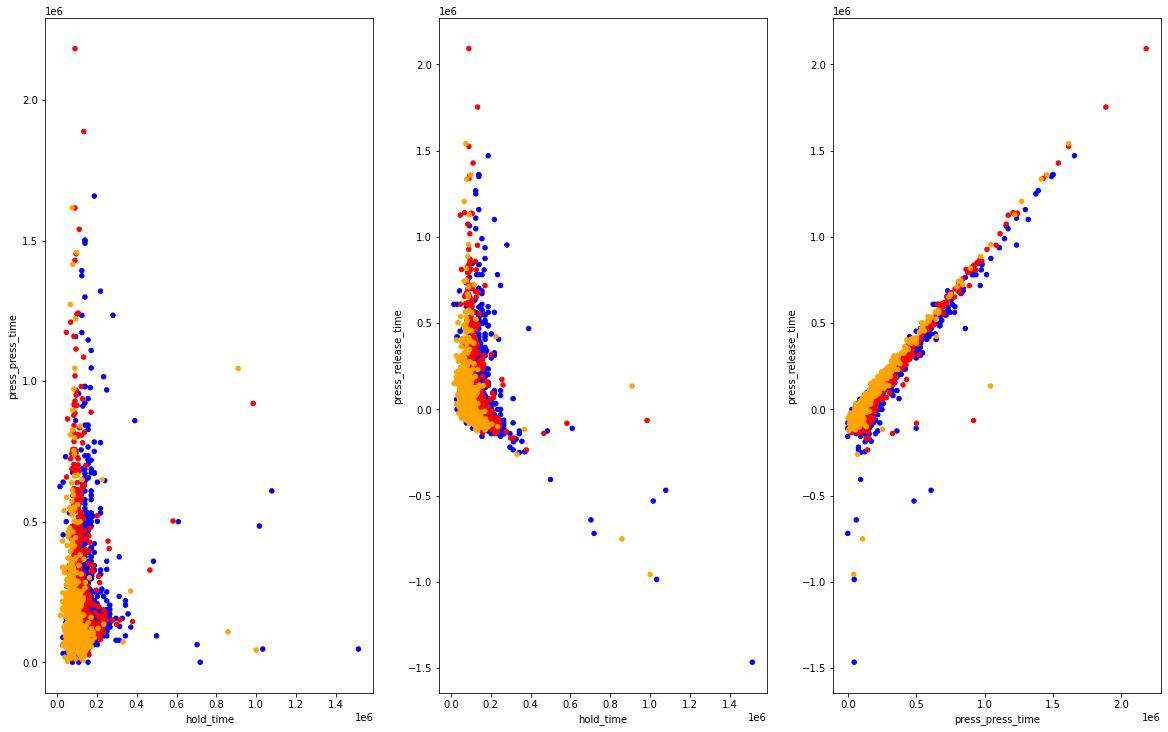

In [24]:
clusterVisualisation(dataframe)

### Building the models

In [25]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import Isomap

import pandas as pd
import glob
import math
import pickle
import json
import numpy as np

#### Loading the data

We first load the data. In order to have our values in a similar scale we use a min-max scaler. The scaler avoids having some data being taken more into account solely because they produce bigger distances between the datapoints, and therefore discriminating more on the weight than on the size.

In [26]:
# Scaling the data and splitting for test and train
def getData(dataframe):
    model_dataframe = dataframe.copy()
    X = model_dataframe[model_dataframe.columns.difference(
            ['user', 'pressed', 'released', 'key'])]

    # Encoding the user column to feed it to the classifier
    lb_make = LabelEncoder()
    model_dataframe['user_code'] = lb_make.fit_transform(model_dataframe["user"])

    y = model_dataframe['user_code'].values

    model_dataframe = model_dataframe.drop(columns=['user'])

    # Splitting the data into test and train sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # Scaling the data
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Saving the scaler
    scalerPickle = open(f'models/scalerpickle_file', 'wb')
    pickle.dump(scaler, scalerPickle)
    
    return X_train, X_test, y_train, y_test

In [27]:
X_train, X_test, y_train, y_test = getData(dataframe)

#### Gradient Boosting

Gradient boosting is a type of machine learning boosting. It's main principle is the notion that a weak learner (a predictor with poor accuracy) had the capability to be modified and become better. These weak learners are usually decision trees. When training, trees are added one at a time, without modifying the existing trees. Every time, the loss function (when used for classification, it's a log loss function) allows us to evaluate and minimize the loss of the model, therefore improving its accuracy. The key idea is to set the target outcomes as the current's missed ones for the next model. Gradient boosting is used to minimize bias errors in the model: it learns a lot without overfitting, which is very fitting for our medium size dataset.

The hyper parameters (learning rate, number of estimators and maximum depth) have been decided empirically after runs with different combinations to get a satisfying accuracy

Gradient Boosting has produced a model that returns a correct result 86% of the time.

In [28]:
# Applying the gradient boosting
def gradientBoosting(X_train, y_train, X_test, y_test):   
    gb = GradientBoostingClassifier(
            n_estimators=1000, learning_rate=0.1, max_depth=12, random_state=0).fit(X_train, y_train)
    print(gb.score(X_test, y_test))
    gbPickle = open('models/gbpickle_file', 'wb')
    pickle.dump(gb, gbPickle)

In [29]:
# Takes some time..
gradientBoosting(X_train, y_train, X_test, y_test)

0.8644222020018199


#### Random Forest Classifier

Random forests are learning methods that can be applied to regression or classification. It is similar to Gradient Boosting in that it creates multiple decisions trees. However, we note two major differences: while gradient boosting aggregates results as it's training, RF classifier aggregates them at the end using a majority rule, and the RF build trees independently whereas gradient boosting creates them one at a time.

Random forests wrk by constructing a large amount of decision trees while training, each with a random subset of the training data. When used for the purposes of classification, the returned result is the class that is selected by the biggest amount of trees. The fact that the trees are random helps to avoid overfitting the model to the given training set, it also is fitting for our use case as it's helping overcome the differences in behavior caused by the user being in the start or end of their typing period.

This method of machine learning managed to create a model with 86% accuracy.

In [30]:
# Applying the random forest classifier
def randomForest(X_train, y_train, X_test, y_test):   
    clf = RandomForestClassifier(max_depth=15, random_state=0).fit(X_train, y_train)
    print(clf.score(X_test, y_test))
    clfPickle = open('models/rfpickle_file', 'wb')
    pickle.dump(clf, clfPickle)

In [31]:
randomForest(X_train, y_train, X_test, y_test)

0.8607825295723385


## Identifying users and intruders

We applied our models to a practical test to determine their efficiency and accuracy in detecting a user based on their typing. We load a model, and a file taken from our keylogger, and test to see which user the model will predict. This sections is a first step to answer our two other questions: **How to define a user's signature using keyboard dynamics?** and **How to detect an intruder in a keyboard dynamics authentication system?**

### Gradient Boosting

In [32]:
# Plotting the probabilities of each user for the gradient boosting
def plotIdentificationGB(gb_result, user):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_axes([0,0,1,1])
    ax.barh(registered_users, gb_result, color='steelblue')
    ax.set_title(f'Probability of {user} being one of the registered (alex, stefan, zineb)')
    plt.show()

In [33]:
# Calculating the user match of the data provided using gradient boosting
def identifyUserGB(dataframe_user, user, plot=True):
    loaded_gb = pickle.load(open('models/gbpickle_file', 'rb'))
    loaded_scaler = pickle.load(open('models/scalerpickle_file', 'rb'))

    X = dataframe_user[dataframe_user.columns.difference(
        ['user', 'pressed', 'released', 'key'])]
    probas = [0, 0, 0]
    
    # Predicting using the gradient booster and getting the proba for each user for each entry
    predictions = loaded_gb.predict_proba(loaded_scaler.transform(X))
    
    # Summing the probas for each entry ot get a global proba per user
    for prediction in predictions:
        for i in range(3):
            probas[i] += prediction[i]
    result = [x / len(X) for x in probas]
    
    if plot == True:
        plotIdentificationGB(result, user)
    return result

#### Identifying a known user

Using Gradient Boosting, the model allows us to accurately identify a user, in this case Alex, with typing being predicted with 98% certainty. On the below graph we see a large contrast between the probabilities for the identified users, and the rest.

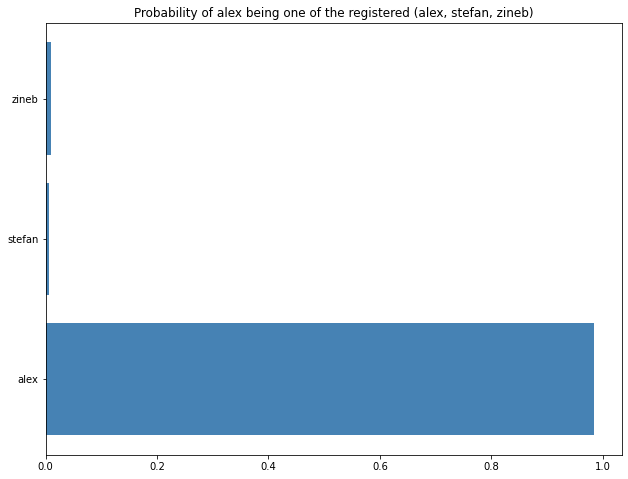

[0.9847120076218999, 0.0057148923087406095, 0.009573100069362635]

In [34]:
user = 'alex'
group = 'registered'
dataframe_reg, stats_reg = loadData(group=group, user=user)
identifyUserGB(dataframe_reg, user=user)

#### Identifying an intruder

When we use an intruder, in this case Zihao (whose dataset was not included in the model training), we see a relatively low degree of accuracy for each of the users, nowhere near the 98% for Alexandre. This indicates couldn't match with high confidence the Zihao's data with one of the registered users. 

With a carefully chosen threshold, this model can efficiently avoid intruders by avoiding to identify them with any of the established users. 

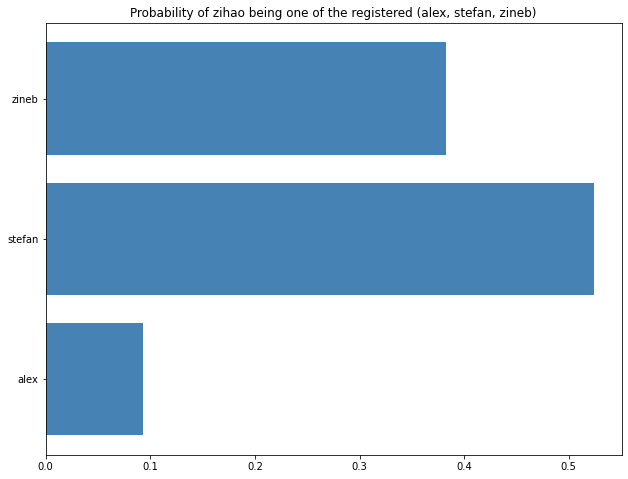

[0.09267437867445665, 0.5242378190627942, 0.3830878022627494]

In [35]:
user = 'zihao'
group = 'intruder'
preprocess(user, group=group)
dataframe_reg, stats_reg = loadData(group=group, user=user)
identifyUserGB(dataframe_reg, user=user)

### Random Forest Classifier

In [36]:
# Plotting the probabilities of each user for the random forest classifier
def plotIdentificationRF(rf_result, user):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_axes([0,0,1,1])
    ax.barh(registered_users, rf_result, color='slateblue')
    ax.set_title(f'Probability of {user} being one of the registered (alex, stefan, zineb)')
    plt.show()

In [37]:
# Calculating the user match of the data provided using the random forest classifier
def identifyUserRF(dataframe_user, user, plot=True):
    loaded_rf = pickle.load(open('models/rfpickle_file', 'rb'))
    loaded_scaler = pickle.load(open('models/scalerpickle_file', 'rb'))
    # Load file
    X = dataframe_user[dataframe_user.columns.difference(
        ['user', 'pressed', 'released', 'key'])]
    probas = [0, 0, 0]
    
    # Predicting using the random forest classifier and getting the proba for each user for each entry
    predictions = loaded_rf.predict_proba(loaded_scaler.transform(X))
    
    # Summing the probas for each entry ot get a global proba per user
    for prediction in predictions:
        for i in range(3):
            probas[i] += prediction[i]
    result = [x / len(X) for x in probas]
    if plot == True:
        plotIdentificationRF(result, user)
    return result

#### Identifying a known user

The Random Forest model managed to successfully identify the correct user using their keystroke data, albeit with less accuracy (92%). 

Furthermore, the contrast between the identified and non identified users is slightly smaller, making the process of finding a threshold harder and less precise in some cases.

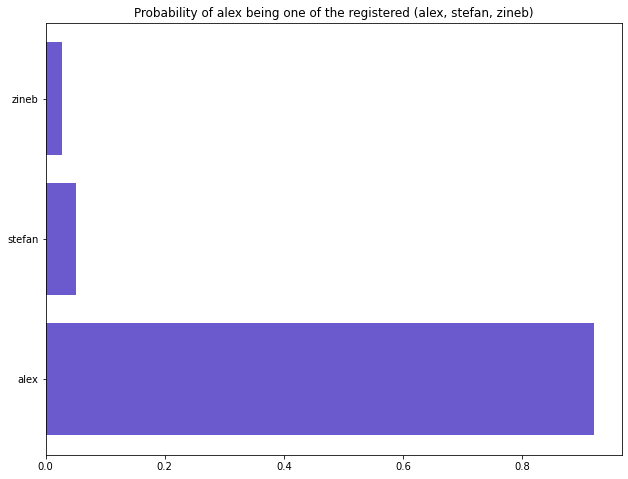

[0.9209247885684443, 0.051192866169377814, 0.02788234526217748]

In [38]:
user = 'alex'
group = 'registered'
dataframe_reg, stats_reg = loadData(group=group, user=user)
identifyUserRF(dataframe_reg, user=user)

#### Identifying an intruder

When an intruder is introduced, one of our users is identified with 63% accuracy, while the other users are around the 16-19% mark. 

While this information can still be interpreted correctly (no user has been identified, we are nowhere near 92%), the margin between the highest prediction and the rest is higher, and 63% remains quite high.

We can conclude that this model is less efficient than the Gradient Boosting model in identifying users, and refusing intruders.

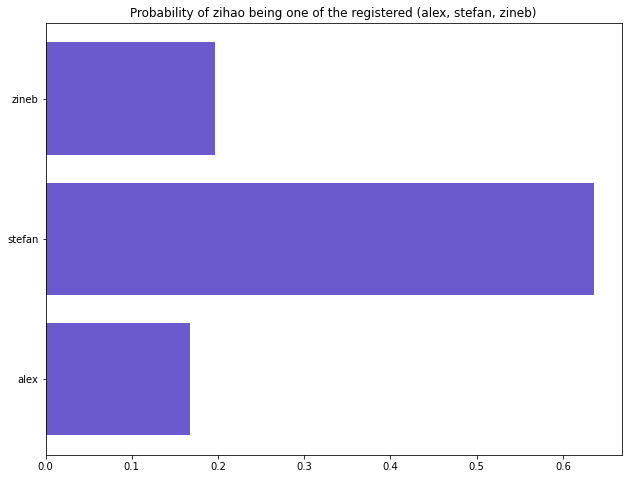

[0.16773753925880291, 0.6361712878387606, 0.19609117290243677]

In [39]:
user = 'zihao'
group = 'intruder'
preprocess(user, group=group)
dataframe_reg, stats_reg = loadData(group=group, user=user)
identifyUserRF(dataframe_reg, user=user)

We have run theses tests for all registered users (alexandre, zineb and stefan).

From these two experiments, we gather some answer elements to our two remaining questions:

**How to define a user's signature using keyboard dynamics?** One of the ways to define a user's signature is to use a classifier trained on the user's log data. We can choose a threshold of 90% for the gradient boosting and 75% for the randnom forest classifier for the users signature judging from our experiments. For example, for the gradient boosting, this means that if the classifier assigns the data with over 90% confidence to one of the registered users, then we are inclined to say they're registered.

**How to detect an intruder in a keyboard dynamics authentication system?** On the contrary, if we introduce some data and the classifier trained on our registered users' data is unable to assert with a confidence over 90% that the data belongs to one of them, we are highly inclided to say that it's an intruder.

### Statistical Analysis

#### Difference-based analysis

We tested a difference-based approach using statistical analysis in order to try to quantify the differences between the typing styles of different users. That can allow to set specific treshold for identifying users based on different measured metrics.

##### Calculating the distance

This methods allows us to compute the distance between two users. We use it in order to calculate the distances in metrics between a user and an intruder (or any two chunks of typing data). We can use that information later in order to compute the necessary threshold to set, so that we can identify a user, but also prevent an intruder from being wrongly identified.

In order to compute the distance, we extract the same amount of data from the user and the intruder, and we calculate the statisctics based on the intruders metrics (see above). We used the Minkowski distance to compute distances. The Minkowski distance is a distance between two points in the normed vector space and is a generalization of the Euclidean distance and the Manhattan distance. The Minkowski distance is based on a parameter p, which can vary between 1 and infinity. A p value of 1 is the Manhattan distance*, and 2 is the Euclidian distance**. The way the optimal value of p is used for each case is done with experimentation, with the most usual values for most cases being 1, 2, 3 or 4. That is why in our method, we calculate 9 Minkowski distances, with values varying between 1 and 9. We will compare their effectiveness in the following part of the report.

Furthermore, we calculate the differences of the APM and Error Rates as additional metrics.

*The Manhattan distance is is the sum of absolute differences between points across all the dimensions.  
**The Euclidian distance is the shortest distance between two points.

In [40]:
# Imports
from scipy.spatial import distance
from sklearn.preprocessing import normalize
from sklearn.utils import shuffle

In [44]:
# Computing the distance between a user and an intruder's data (or a user's chunk)
def compute_distance(cluster, intruder):

    # Scaling the data
    user = cluster["user"].iloc[0]
    scaler = MinMaxScaler()
    # We're not scaling string values, timestamp and user
    cols = ["key","pressed", "released", "user"]
    val_columns=intruder.columns.difference(cols)
    intruder_dropped = intruder[val_columns]
    scaler.fit(intruder_dropped)
    intruder_data = scaler.transform(intruder_dropped)
    
    # Adding back columns that weren't to be scaled (string values, timestamp and user)
    reconstructed = pd.DataFrame(data=intruder_data, columns=val_columns)
    for col in cols:
        reconstructed[col] = intruder[col].values
        
    # Calculating the statistics for the scaled data
    stats = compute_statistics(reconstructed)
    
    # Keeping the non scaled data to calculate apm and error rate
    non_scaled_stats = compute_statistics(intruder)
    intruder_apm = non_scaled_stats.pop('apm', None)
    intruder_error_rate = non_scaled_stats.pop('error_rate', None)
    [ stats.pop(x, None) for x in ["user", "apm", "error_rate"] ]
    stats = [*stats.values()]

    # Scaling the data
    cluster_dropped = cluster[val_columns]
    scaler.fit(cluster_dropped)
    cluster_data = scaler.transform(cluster_dropped)
    reconstructed = pd.DataFrame(data=cluster_data, columns=val_columns)
    for col in cols:
        reconstructed[col] = cluster[col].values
        
    # Calculating the statistics for the scaled data
    cluster_stats = compute_statistics(reconstructed)
    
    # Keeping the non scaled data to calculate apm and error rate
    non_scaled_stats = compute_statistics(cluster)
    cluster_apm = non_scaled_stats.pop('apm', None)
    cluster_error_rate = non_scaled_stats.pop('error_rate', None)
    [ cluster_stats.pop(x, None) for x in ["user", "apm", "error_rate"] ]
    cluster_stats = [*cluster_stats.values()]

    # Calculating the distance
    # Minkowski with p=1 is Manhattan, we iterate over multiple values of p
    dists = []
    for i in range(1, 10):
        dists.append(distance.minkowski(stats, cluster_stats, i))

    # From experiments we have chosen p=1 as it gives the best results
    dist = distance.minkowski(stats, cluster_stats, 1)
    apm_diff = abs(cluster_apm - intruder_apm)
    error_rate_diff = abs(cluster_error_rate - intruder_error_rate)
    
    return dist, dists, apm_diff, error_rate_diff, user

##### Finding the distance threshold for knwon users

We apply the above method firstly on the known users, in order to determine the variations of metrics that can happen for a single users, so that we have founded thresholds for us to reject or not the intruder's data if it varies from one of our registered users.

A user's metrics can vary over time, and depending on different conditions (the type and difficuly of text typed, their energy and focus etc.).

That is why, firsly, for each user we determine the average distance that is found. We do that by shuffling the dataset for the user (in order to avoid getting chuncks of only one typing style of the user). We keep a part of the data as the user data, and then the rest is divided in chunks that we test against. These chunks are about the size of the expected intruder's data. We compute the distance between the kept user data and each of the chuncks, repeating that multiple times (a 100 in our case). Finally we compute the average distances for the user. This finally gives us the thresholds needed to be set for each metric for each user to take into account the typing variations of each user.

In [45]:
# Calculating distance of users to chunks of their data in order to define thresholds of acceptance 
def getDistanceThresholds():
    distance_per_user = {}
    distances_per_user = {}
    error_rate_per_user = {}
    apm_diff_per_user = {}
    
    for user in registered_users:
        distances = []
        distances_dists = []
        apms = []
        errors = []
        for i in range(100):
            # Keep 1000 first rows for user clusters
            input = shuffle(pd.read_csv(f'datasets/registered/{user}_data.csv'))
            cluster = input.iloc[:1000,:]
            remaining = input.iloc[1000:,:]

            # Divide the remaining rows into 200 rows chunks (~ 4 sentences text)
            chunk_size = 200
            cursor = 0
            while cursor < (len(remaining) //  chunk_size)*chunk_size:
                chunk = remaining.iloc[cursor:cursor+chunk_size,:]
                # Calculating the distance and saving them 
                dist, dists, apm_diff, error_rate_diff, user = compute_distance(cluster, chunk)
                distances.append(dist)
                distances_dists.append(dists)
                apms.append(apm_diff)
                errors.append(error_rate_diff)
                cursor += chunk_size

        # Averaging calculated values over the 100 runs
        avg_dist = sum(distances)/len(distances)
        
        # Calculating the average distances per p value
        dists_sum = [0] *9
        for d in distances_dists:
            for i in range(9):
                dists_sum[i]+=d[i]
        for i in range(9):
            dists_sum[i] = dists_sum[i]/len(distances)
            
        distance_per_user[user] = avg_dist
        distances_per_user[user] = dists_sum
        avg_error = sum(errors)/len(errors)
        error_rate_per_user[user] = avg_error
        avg_apm = sum(apms)/len(apms)
        apm_diff_per_user[user] = avg_apm

    return {
        'dist': distance_per_user,
        'distances_p_values' : distances_per_user,
        'error_rate':error_rate_per_user,
        'apm':apm_diff_per_user
    }
# compute the distance between each chunk and the corresponding cluster
# define a threshold for intruder data

In [46]:
# This takes time..
getDistanceThresholds()

{'dist': {'alex': 0.7642841666354053,
  'stefan': 0.23665517670405048,
  'zineb': 0.6874550505121215},
 'distances_p_values': {'alex': [0.7642841666354053,
   0.6009804798942614,
   0.5789827626560708,
   0.5735309523400093,
   0.5717393091166294,
   0.5710325065125225,
   0.5707121818343596,
   0.5705491507274566,
   0.5704573939217222],
  'stefan': [0.23665517670405048,
   0.1721318701769795,
   0.16205425419756014,
   0.15887158994508677,
   0.15748758892952594,
   0.15676502722467495,
   0.15634151534785568,
   0.15607278812283204,
   0.15589211794329205],
  'zineb': [0.6874550505121215,
   0.5296801042010363,
   0.5069462238448484,
   0.5006001885569173,
   0.4982560909324431,
   0.49723183441008084,
   0.49672439615508873,
   0.49644519583987384,
   0.49627710976187694]},
 'error_rate': {'alex': 1.132,
  'stefan': 1.4995000000000003,
  'zineb': 1.1880000000000002},
 'apm': {'alex': 17.0576251747599,
  'stefan': 19.07170955565487,
  'zineb': 21.840228810018154}}

These are the threshold we decide on after running the previous algorithm about 10 times. (Manhattan distances only)

In [47]:
decided_thresholds = {
    'dist': {
        'alex': 0.8,
        'stefan': 0.25,
        'zineb': 0.65
    },
    'error_rate': {
        'alex': 1.1,
        'stefan': 1.45,
        'zineb': 1.25,
    },
    'apm': {
        'alex': 17.5,
        'stefan': 17,
        'zineb': 23,
    }
}

##### Calculating the intruder's distance

We use the extracted data, and put it to the test against an intruder. For the intruder we calculate the distances with each user. We can now have values for the distances of the intruder for each of the values of P. We can then see how big the margin between the distance found for the user thresholds and the distances of the intruder. While all of the results are over the thresholds set for all of the users, the margin is the largest between the two for the value of P=1, or the Manhattan distance (please see the table below, the red-green color scale indicates lowest to highest absolute difference). This is why we are going to move forward by using the Manhattan distance for our analysis.

We can conclude by comparing the distances of the inturder and thresholds set previously, that the distances in most cases are over the thresholds, which means that the distance is sufficient to identify an intruder. 

![Alt text](./image.png?raw=true "Values of P - Users v Intruders")

In [48]:
# Getting the distance of an intruder (identified by their username and user group (=name of folder where preprocess dataset is))
def getDistance(usergroup, username):
    dataframe = pd.read_csv(f'datasets/{usergroup}/{username}_data.csv')
    distances = {}
    # Calculating the distance to each registered user
    for user in registered_users:    
        dist, dist_euclid, apm_diff, error_rate_diff, user = compute_distance(pd.read_csv(f'datasets/registered/{user}_data.csv'), dataframe)
        distances[user] = {
            'dist':dist,
            'dist_euclid':dist_euclid,
            'apm':apm_diff,
            'error_rate':error_rate_diff
        }
    return distances

In [49]:
getDistance('intruder', 'zihao')

{'alex': {'dist': 1.1103206393660394,
  'dist_euclid': [1.1103206393660394,
   0.867462524076569,
   0.8377303833902957,
   0.8319711597470614,
   0.8306928500881197,
   0.8303891073366477,
   0.8303137589688996,
   0.8302944988428547,
   0.8302894660809254],
  'apm': 20.972249117819388,
  'error_rate': 1.0605486032107194},
 'stefan': {'dist': 0.25083684533262496,
  'dist_euclid': [0.25083684533262496,
   0.1870293027100268,
   0.17819597039332427,
   0.17616610479461725,
   0.17562277346271776,
   0.17546656286746015,
   0.1754196516463055,
   0.17540513266153787,
   0.1754005380893892],
  'apm': 18.23337606806956,
  'error_rate': 1.396789280748325},
 'zineb': {'dist': 0.9860876386407207,
  'dist_euclid': [0.9860876386407207,
   0.726809936147874,
   0.692708480023792,
   0.6852370338337159,
   0.6833060971314997,
   0.682766889594825,
   0.6826092940959991,
   0.6825617950873442,
   0.6825471551575424],
  'apm': 124.69763082676252,
  'error_rate': 0.6509922892175455}}

### Decision

We apply all of the analysis and approaches that we've examined to a practical example. 

We have developped a method that takes a dataset of typing data and tests it against a base of registered users for the purpose of identifying the user, either as one of the registered profiles, or as an intruder.

We compute the probability of a match using gradient boosting and the random forest method which give us registered user candidates that we can potentially identify with. Then, we calculate the distances for all of the metrics, as outlined in our statistical approach.

If the test data passes all of the evaluations, the user is successfuly identified.

In [63]:
# Mapping user to user number
registered = {
    0: 'alex',
    1: 'stefan',
    2: 'zineb'
}
# Decisive metrics
metrics = ['apm', 'error_rate', 'dist']

# Getting the decision on whether a user (for which the preprocessed data is in usergroup/username_data.csv) is registered
def getDecision(username, usergroup):
    preprocess(username, group=usergroup)
    dataframe, stats = loadData(group=usergroup, user=username)
    
    decisions = []
    
    # Getting the candidate registered users by the gradient boosting
    print('------> Preliminary results:')
    results_gb = identifyUserGB(dataframe, user=username, plot=False)
    id_gb = np.amax(results_gb) > 0.9
    decisions.append(id_gb)
    candidate_gb = registered[np.argmax(results_gb)] 
    print(f'Gradient boosting identified {candidate_gb} with a proba of {np.amax(results_gb)} -> indicating {id_gb}')
    
    # Getting the candidate registered users by the random forest classifier
    results_rf = identifyUserRF(dataframe, user=username, plot=False) 
    id_rf = np.amax(results_rf) > 0.75
    decisions.append(id_rf)
    candidate_rf = registered[np.argmax(results_rf)]
    print(f'Random Forest identified {candidate_rf} with a proba of {np.amax(results_rf)} -> indicating {id_rf}')
    
    candidates = set([candidate_gb, candidate_rf])
    
    thresholds = decided_thresholds
    differences = getDistance(usergroup, username)
    
    # Calculating the distances and checking whether they are under the threshold
    for metric in metrics:
        for candidate in candidates:
            distance = differences[candidate][metric]
            threshold = thresholds[metric][candidate]
            res = distance < threshold
            decisions.append(res)
            print(f'Distance from {user} to candidate {candidate} for {metric}: {distance}, threshold = {threshold} -> indicating {res}')
    
    # Final decision
    print()
    final_decision = 'Yes' if all(value == True for value in decisions) else 'No'
    print(f"------> Final decisions: Is {user} a registered user? {final_decision}")

In [65]:
# User group = folder name
getDecision('zihao', 'intruder')

------> Preliminary results:
Gradient boosting identified stefan with a proba of 0.5242378190627942 -> indicating False
Random Forest identified stefan with a proba of 0.6361712878387606 -> indicating False
Distance from zihao to candidate stefan for apm: 18.26357080264478, threshold = 17 -> indicating False
Distance from zihao to candidate stefan for error_rate: 1.392552170178364, threshold = 1.45 -> indicating True
Distance from zihao to candidate stefan for dist: 0.25092868306849414, threshold = 0.25 -> indicating False

------> Final decisions: Is zihao a registered user? No
